In [26]:
#library imports
import math
from collections import namedtuple
from fractions import Fraction 
from copy import copy
import numpy as np
from numpy.linalg import inv
from sympy import symbols
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [27]:
#some boilerplate code
x = symbols('x')
#Equation = namedtuple('Equation',('a','b'))
Conditions = namedtuple('Conditions',('n','f0','F0','Fn','h','e'))

In [28]:
%%latex
\begin{align}
f''' - ff'' + 1 - (f')^2 = 0\\
f_0 = 0\\
f'_0 = 0\\
f'_n = 1\\
n = 10\\
\end{align}

<IPython.core.display.Latex object>

In [29]:
def initializer(cond):
    Vals = np.zeros((2, cond.n + 1))
    #Vals[0] = np.arange()
    Vals[1][-1] = cond.Fn
    return Vals

In [55]:
def Finite_Diff_Solver(cond, f_k, verbose=True):
    n = cond.n
    a, b, c, d = np.zeros((n-2, 2, 2)), np.zeros((n-1, 2, 2)),\
    np.zeros((n-2, 2, 2)), np.zeros((n-1, 2))
    #A
    b[0] = np.array([[1.0, -cond.h/2.0], [-(f_k[1][2] - f_k[1][0])/(2.0*cond.h),\
                                          (-2.0/cond.h**2 - 2.0*f_k[1][1])]])
    c[0] = np.array([[0.0, 0.0], [0.0, 1.0/cond.h**2 - f_k[0][1]/(2.0*cond.h)]])
    b[n-2] = np.array([[1.0, -cond.h/2.0], [-(f_k[1][-1] - f_k[1][-3])/(2.0*cond.h),\
                                          (-2.0/cond.h**2 - 2.0*f_k[1][-2])]])
    a[n-3] = np.array([[-1.0, -cond.h/2.0], [0.0, 1.0/cond.h**2 + f_k[0][-2]/(2.0*cond.h)]])
    #d
    d[0] = np.array([0.0, -1.0 - f_k[0][1]*(f_k[1][2] - f_k[1][0])/(2.0*cond.h) -\
                     f_k[1][1]**2])
    d[n-2] = np.array([0.0, -1.0 - f_k[0][-2]*(f_k[1][-1] - f_k[1][-3])/(2.0*cond.h) -\
                       f_k[1][-2]**2 - 1.0/cond.h**2 + f_k[0][-2]/(2.0*cond.h)])
    for i, xi in enumerate(np.arange(1, cond.n-2), start=1):
        #print(i)
        a[i-1] = np.array([[-1.0, -cond.h/2.0], [0.0, 1.0/cond.h**2 +\
                                                 f_k[0][i+1]/(2.0*cond.h)]])
        b[i] = np.array([[1.0, -cond.h/2.0], [-(f_k[1][i+2] - f_k[1][i])/(2.0*cond.h),\
                                          (-2.0/cond.h**2 - 2.0*f_k[1][i+1])]])
        c[i] = np.array([[0.0, 0.0], [0.0, 1.0/cond.h**2 - f_k[0][i+1]/(2.0*cond.h)]])
        d[i] = np.array([0.0, -1.0 - f_k[0][i+1]*(f_k[1][i+2] - f_k[1][i])/(2.0*cond.h)\
                         - f_k[1][i+1]**2])
        
    if verbose:
        print("A={}, B={}, C={}, D={}".format(a,b,c,d))
        
    return (a,b,c,d)

In [31]:
def Thomas_Algorithm(coeff, cond):
    a, b, c, d = coeff
    n = cond.n
    c1 = np.zeros((n-2, 2, 2))
    d1 = np.zeros((n-1, 2))
    #print(b[0])
    c1[0] = inv(b[0]).dot(c[0])
    d1[0] = inv(b[0]).dot(d[0])
    #print(d1.shape)
    for i in range(1,n-2):
        t1 = b[i]-a[i-1].dot(c1[i-1])
        c1[i] = inv(t1).dot(c[i])
        d1[i] = inv(t1).dot(d[i] - a[i-1].dot(d1[i-1]))
    d1[n-2] = inv(b[n-2] - a[n-3].dot(c1[n - 3])).dot(d[n-2] - a[n-3].dot(d1[n-3]))
    def backsubstitution(c,d):
        y = np.zeros_like(d)
        y[-1] = d[-1]
        cache = y[-1]
        #print(cache.shape)
        for i in reversed(range(d.shape[0]-1)):
            y[i] = d[i] - c[i].dot(cache)
            cache = y[i]
        return y
    fin_y = backsubstitution(c1,d1)
    #print(fin_y.shape)
    #print(fin_y)
    Fn = cond.Fn
    fn = cond.h/2.0 * (fin_y.T[1][-1] + Fn) + fin_y.T[0][-1]
    y = np.concatenate((fin_y, np.array([[fn, Fn]])))
    y = np.concatenate((np.array([[cond.f0, cond.F0]]), y))
    #print(y)
    return y.T

In [32]:
def Newton_Solver(cond):
    print(cond.n)
    #print(initializer(cond))
    y_k = initializer(cond)
    #print(y_k)
    tuples_coeff = Finite_Diff_Solver(cond, y_k, verbose=False)
    y_k1 = Thomas_Algorithm(tuples_coeff, cond)
    s = np.max(abs(y_k1[0] - y_k[0]))
    #print(s)
    solutions = []
    while(s > cond.e):
        y_k = copy(y_k1)
        solutions.append(y_k)
        tuples_coeff = Finite_Diff_Solver(cond, y_k, verbose=False)
        y_k1 = Thomas_Algorithm(tuples_coeff, cond)
        s = np.max(abs(y_k1[0] - y_k[0]))
        #print(s)
        
    y_k = y_k1
    solutions.append(y_k)
    return solutions

In [33]:
cond = Conditions(100,0.0,0.0,1.0,0.1,0.001)

In [51]:
y = Newton_Solver(cond)

100


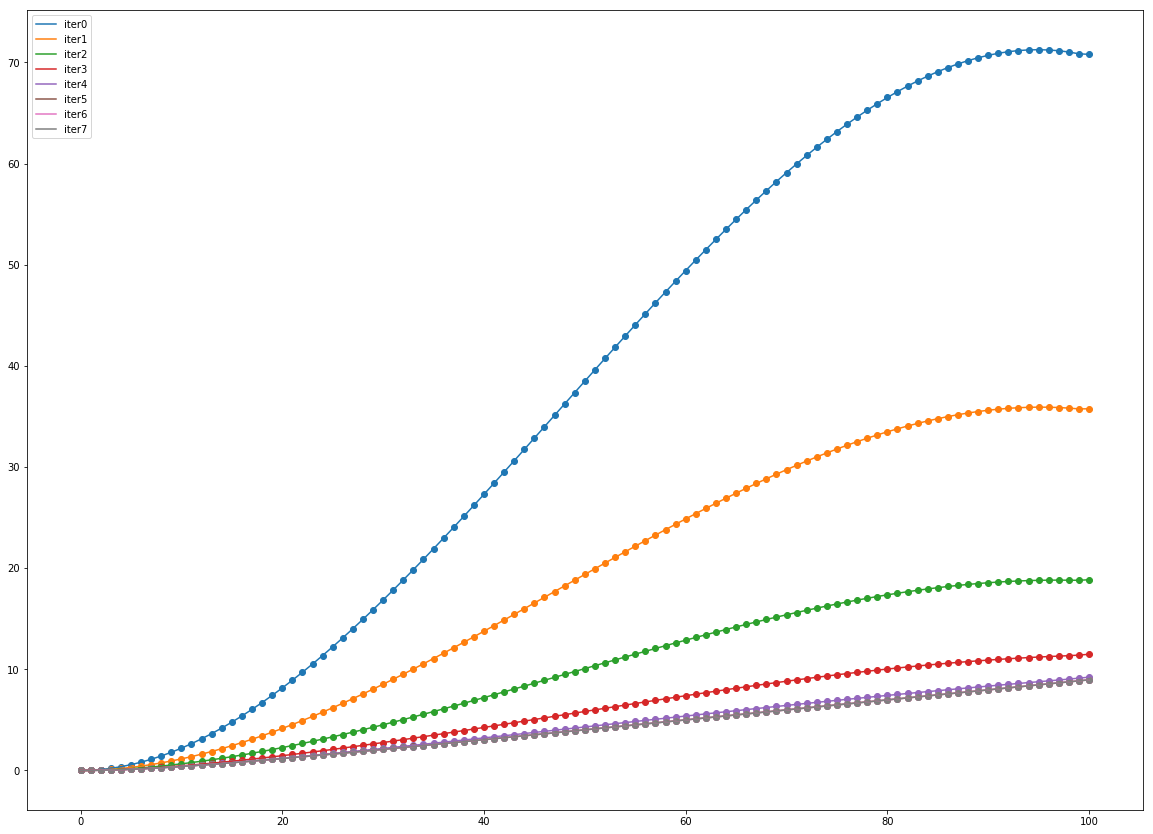

In [52]:
x_range = np.arange(0, cond.n + 1)
fig = plt.figure(figsize=(20, 50))
ax = fig.add_subplot(311)
g = []
for i in range(len(y)):
    ax.plot(x_range, y[i][0])
    ax.scatter(x_range, y[i][0])
    g.append("iter"+str(i))
ax.legend(tuple(g))
fig.show()

10


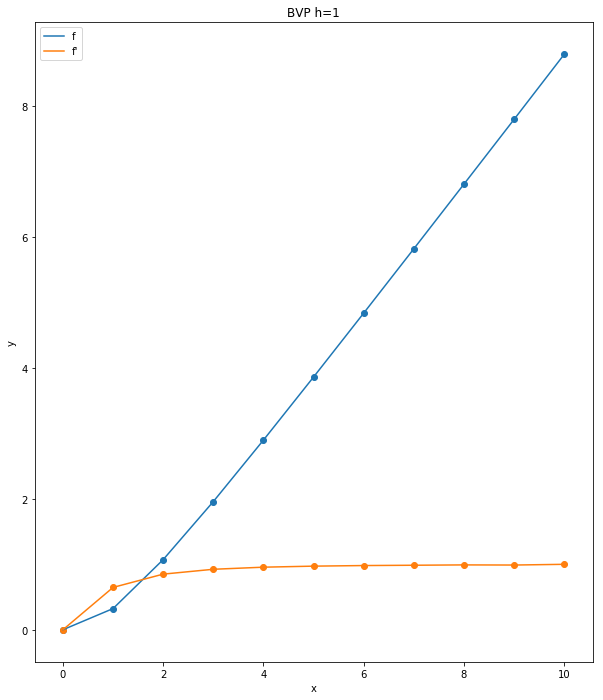

In [53]:
cond = Conditions(10,0.0,0.0,1.0,1,0.001)
y = Newton_Solver(cond)
x_range = np.arange(0, cond.n + 1)
fig = plt.figure(figsize=(10,40))
x_range = np.arange(0, cond.n + 1)
ax = fig.add_subplot(311)
ax.plot(x_range, y[-1][0])
ax.scatter(x_range, y[-1][0])
ax.plot(x_range, y[-1][1])
ax.scatter(x_range, y[-1][1])
ax.legend(('f','f\''))
ax.set(title="BVP h=1", xlabel="x", ylabel="y")
fig.show()

100


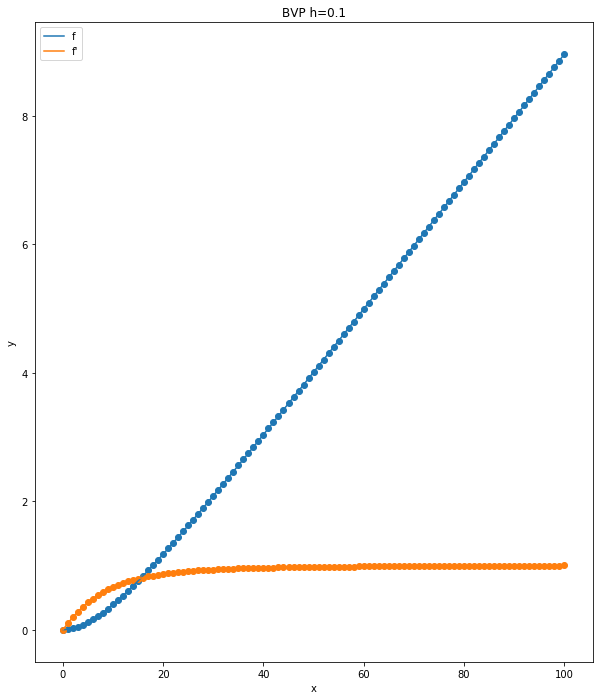

In [54]:
cond = Conditions(100,0.0,0.0,1.0,0.1,0.001)
y = Newton_Solver(cond)
x_range = np.arange(0, cond.n + 1)
fig = plt.figure(figsize=(10,40))
x_range = np.arange(0, cond.n + 1)
ax = fig.add_subplot(311)
ax.plot(x_range, y[-1][0])
ax.scatter(x_range, y[-1][0])
ax.plot(x_range, y[-1][1])
ax.scatter(x_range, y[-1][1])
ax.set(title="BVP h=0.1", xlabel="x", ylabel="y")
ax.legend(('f','f\''))
fig.show()